In [6]:
import numpy as np
import pandas as pd 
import tensorflow as tf

# Imports packages to view data
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os
from skimage.io import imread
import cv2
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate

# Import keras packages
from keras import applications
from tensorflow.keras.optimizers import RMSprop,Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils.data_utils import Sequence
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

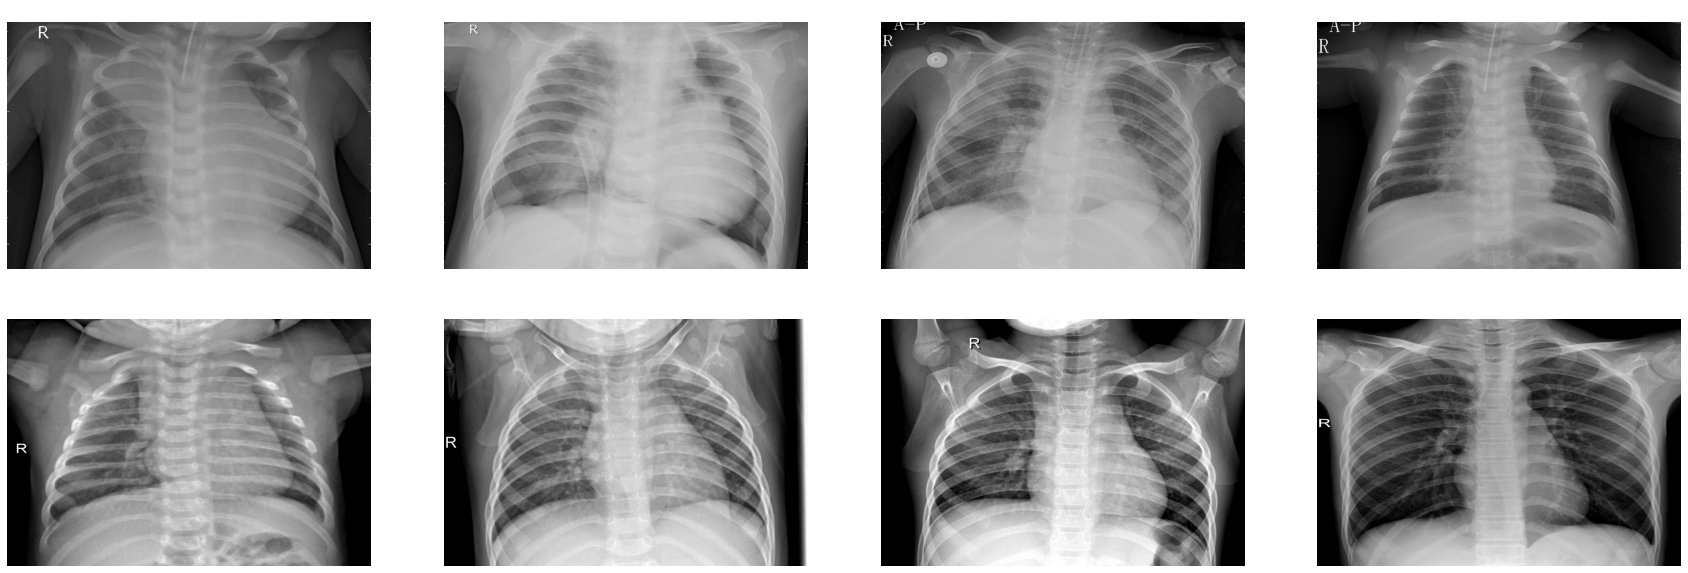

In [11]:

normal_cases_dir ='./chest_xray/chest_xray/train/NORMAL/'
pneumonia_cases_dir ='./chest_xray/chest_xray/train/PNEUMONIA/'
normal_cases = glob(normal_cases_dir+'/*.jpeg')
pneumonia_cases = glob(pneumonia_cases_dir+'/*.jpeg')
train_data = []
for img in normal_cases:
    train_data.append((img,0))
for img in pneumonia_cases:
    train_data.append((img, 1))
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)
train_data = train_data.sample(frac=1.).reset_index(drop=True)
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:4]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:4]).tolist()

samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

f, ax = plt.subplots(2,4, figsize=(30,10))

for i in range(8):
    img = imread(samples[i])
    ax[i//4, i%4].imshow(img, cmap='gray')
    if i<4:
        ax[i//4, i%4].set_title("Pneumonia")
    else:
        ax[i//4, i%4].set_title("Normal")
    ax[i//4, i%4].axis('off')
    ax[i//4, i%4].set_aspect('auto')
plt.show()

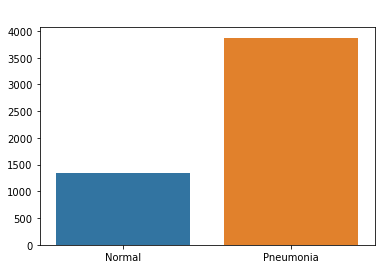

In [15]:
path = './chest_xray'
# plt.rcParams['axes.labelcolor'] = 'w'

train_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(path+'/train/NORMAL', filename) 
                     for filename in os.listdir(path+'/train/NORMAL')])], 
     'Pneumonia': [len([os.path.join(path+'/train/PNEUMONIA', filename) 
                        for filename in os.listdir(path+'/train/PNEUMONIA')])]})


sns.barplot(data=train_samplesize).set_title('Training Set Data', fontsize=20)
plt.show()

In [19]:
training_images = tf.io.gfile.glob('./chest_xray/train/*/*')
validation_images = tf.io.gfile.glob('./chest_xray/val/*/*')

total_files = training_images
total_files.extend(validation_images)
print(f'Total number of images : training_images + validation_images = {len(total_files)}\n')

train_images, val_images = train_test_split(total_files, test_size = 0.2)
print(f'After division of 80:20')
print(f'Total number of training images = {len(train_images)}')
print(f'Total number of validation images = {len(val_images)}')

Total number of images : training_images + validation_images = 5232

After division of 80:20
Total number of training images = 4185
Total number of validation images = 1047


In [20]:
tf.io.gfile.makedirs('./val_dataset/negative/')
tf.io.gfile.makedirs('./val_dataset/positive/')
tf.io.gfile.makedirs('./train_dataset/negative/')
tf.io.gfile.makedirs('./train_dataset/positive/')

In [21]:
for ele in train_images:
    parts_of_path = ele.split('/')

    if 'PNEUMONIA' == parts_of_path[-2]:
        tf.io.gfile.copy(src = ele, dst = './train_dataset/positive/' +  parts_of_path[-1])
    else:
        tf.io.gfile.copy(src = ele, dst = './train_dataset/negative/' +  parts_of_path[-1])

# Validation images
for ele in val_images:
    parts_of_path = ele.split('/')

    if 'PNEUMONIA' == parts_of_path[-2]:
        tf.io.gfile.copy(src = ele, dst = './val_dataset/positive/' +  parts_of_path[-1])
    else:
        tf.io.gfile.copy(src = ele, dst = './val_dataset/negative/' +  parts_of_path[-1])

In [22]:
image_size = 150
epochs = 50
batch_size = 32

In [24]:
train_datagen = ImageDataGenerator(rescale = 1/255,
                                   zoom_range = 0.3,
                                   # width_shift_range = 0.1,
                                   # height_shift_range = 0.1, 
                                   # horizontal_flip = True,
                                   # samplewise_center = True, 
                                   # rotation_range = 0.3,
                                   # samplewise_std_normalization = False, 
                                   # featurewise_std_normalization = False,
                                   vertical_flip=True)

val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

train_gen = train_datagen.flow_from_directory(
    './train_dataset/',
    target_size = (image_size, image_size),
    batch_size = batch_size ,
    class_mode = 'binary'
)

validation_gen = val_datagen.flow_from_directory(
    './val_dataset/',
    target_size = (image_size, image_size),
    batch_size = batch_size ,
    class_mode = 'binary'
)

test_gen = test_datagen.flow_from_directory(
     './chest_xray/test',
    target_size = (image_size, image_size),
    batch_size = batch_size , 
    class_mode = 'binary'
)

Found 4185 images belonging to 2 classes.
Found 1047 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [25]:
count_normal = len([x for x in train_images if "NORMAL" in x])
count_pneumonia = len([x for x in train_images if "PNEUMONIA" in x])

bias = np.log([count_pneumonia/count_normal])
bias

weight_for_0 = (1 / count_normal)*(len(train_images))/2.0 
weight_for_1 = (1 / count_pneumonia)*(len(train_images))/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.93
Weight for class 1: 0.67


In [26]:
checkpoint = ModelCheckpoint(filepath='best_weights.CNN', 
                             save_best_only=True 
                             #save_weights_only=True
                            )
lr_reduce = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.3, 
                              patience=2, 
                              verbose=2, 
                              mode='max')

In [28]:
CNN = tf.keras.models.Sequential([
    
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu',padding='same', input_shape=(image_size, image_size, 3)),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu',padding='same'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # The third convolution
    tf.keras.layers.SeparableConv2D(64, (3,3), activation='relu',padding='same'),
    tf.keras.layers.SeparableConv2D(64, (3,3), activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # The fourth convolution
    tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu',padding='same'),
    tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # The fifth convolution
    tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu',padding='same'),
    tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    
    # Output layer, only 1 output neuron: it will contain a value from 0-1 
    tf.keras.layers.Dense(1, activation='sigmoid'),
    
])


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2021-12-30 17:12:00.497483: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-30 17:12:00.497685: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [29]:
CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 32)        9248      
                                                                 
 batch_normalization (BatchN  (None, 75, 75, 32)       128       
 ormalization)                                          

In [30]:
CNN.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy','Recall', 'Precision'])

In [31]:
histCNN = CNN.fit_generator(
    train_gen, 
    steps_per_epoch = train_gen.samples // batch_size, 
    epochs = epochs, 
    validation_data = validation_gen, 
    validation_steps = validation_gen.samples // batch_size, 
    class_weight = class_weight, 
    callbacks = [checkpoint, lr_reduce])

/var/folders/db/q45d2_5d0c52zkvrdw9tp0xm0000gn/T/ipykernel_23311/2671982376.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  histCNN = CNN.fit_generator(
2021-12-30 18:45:07.988932: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/50


2021-12-30 18:45:08.461458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


130/130 [==============================] - ETA: 0s - loss: 0.4115 - accuracy: 0.8091 - recall: 0.7935 - precision: 0.9396

2021-12-30 18:45:45.076748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-30 18:45:51.086784: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: best_weights.CNN/assets
130/130 [==============================] - 44s 284ms/step - loss: 0.4115 - accuracy: 0.8091 - recall: 0.7935 - precision: 0.9396 - val_loss: 0.5994 - val_accuracy: 0.7461 - val_recall: 1.0000 - val_precision: 0.7461 - lr: 0.0010
Epoch 2/50
130/130 [==============================] - 37s 284ms/step - loss: 0.2800 - accuracy: 0.8863 - recall: 0.8775 - precision: 0.9660 - val_loss: 1.2394 - val_accuracy: 0.7480 - val_recall: 1.0000 - val_precision: 0.7480 - lr: 0.0010
Epoch 3/50
130/130 [==============================] - 37s 284ms/step - loss: 0.2679 - accuracy: 0.8897 - recall: 0.8809 - precision: 0.9676 - val_loss: 1.2666 - val_accuracy: 0.7480 - val_recall: 1.0000 - val_precision: 0.7480 - lr: 0.0010
Epoch 4/50
130/130 [==============================] - 37s 285ms/step - loss: 0.2553 - accuracy: 0.9025 - recall: 0.8937 - precision: 0.9724 - val_loss: 1.4662 - val_accuracy: 0.7441 - val_recall: 1.0000 - val_precision: 0.7441 - lr: